In [1]:
# %load_ext autoreload
%reload_ext autoreload
%autoreload 2
import numpy as np

from src.GridWorldMDP.objectworld_utils import draw_path, generate_demonstrations, init_object_world, visitation_frequency
from src.deepmaxent_irl_objectworld import run_deepmaxent_irl
from src.maxent_irl_objectworld import run_maxent_irl
from src.img_utils import Visualizer, get_evd, draw_evd
from src.argument_parser import get_parser, parse_args_str

PARSER = get_parser()

In [2]:
np.random.seed(1)
BASIC_ARGS = """
--exp_name test
--height 6
--n_objects 50
--n_colours 6
--height 16
--width 16
--seed 2
--n_trajs 10
--n_query 1
--device cpu
"""
args = parse_args_str(PARSER, BASIC_ARGS)
print(args.exp_name)

init_start_pos = np.random.randint(0, args.height, size=(args.n_query, 2)).tolist()
print('start positions: ', init_start_pos)

# env, P_a, rewards_gt, values_gt, policy_gt, feat_map = init_object_world(args)
# env.grid

test
start positions:  [[5, 11]]


In [50]:
for i, s in enumerate(env.get_states()):
    if i == 16:
        break

In [16]:
import torch
import torch.nn as nn
from src.deepmaxent_irl import demo_svf

trajs = generate_demonstrations(env, policy_gt, 
                                n_trajs=args.n_query, 
                                len_traj=args.l_traj, 
                                rand_start=True, 
                                start_pos=None)
device = torch.device(args.device)
N_STATES, _, N_ACTIONS = np.shape(P_a)
mu_D = demo_svf(trajs, N_STATES)
inputs = torch.from_numpy(feat_map).float().to(device)


In [38]:
np.arange(0, 9).reshape((3, 3), order='F')

array([[0, 3, 6],
       [1, 4, 7],
       [2, 5, 8]])

In [40]:
feat_map[16]

array([ 7.81024968,  2.        ,  5.        ,  9.05538514,  9.43398113,
       10.44030651,  2.        ,  7.07106781,  7.07106781, 10.29563014,
        5.83095189,  5.        ])

In [39]:
feat_map.reshape(args.height, args.width, -1, order='F')[0, 1]

array([ 7.81024968,  2.        ,  5.        ,  9.05538514,  9.43398113,
       10.44030651,  2.        ,  7.07106781,  7.07106781, 10.29563014,
        5.83095189,  5.        ])

In [55]:
inputs.reshape(args.height, args.width, -1).permute(1, 0, 2)[0, 1]

tensor([ 7.8102,  2.0000,  5.0000,  9.0554,  9.4340, 10.4403,  2.0000,  7.0711,
         7.0711, 10.2956,  5.8310,  5.0000])

In [60]:
np.sqrt(inputs.size(0)).astype(int)

16

In [67]:
input_dim = 2*args.n_colours
height = np.sqrt(inputs.size(0)).astype(int)
inputs_img = inputs.view(height, height, input_dim).permute(2, 1, 0)[None,]
inputs_img[0, :, 0, 1]

tensor([ 7.8102,  2.0000,  5.0000,  9.0554,  9.4340, 10.4403,  2.0000,  7.0711,
         7.0711, 10.2956,  5.8310,  5.0000])

In [92]:
output_dim = 1
hiddens = [8, 8, output_dim]
layers = nn.Sequential(
    nn.Conv2d(input_dim, hiddens[0], kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.Dropout(0.25),
    nn.Conv2d(hiddens[0], hiddens[1], kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Conv2d(hiddens[1], hiddens[2], kernel_size=3, stride=1, padding=1),
    nn.Tanh()
)

# cnn_layer = nn.Conv2d(input_dim, 8, kernel_size=3, stride=1, padding=0)
o = layers(inputs_img).squeeze()
o.permute(1, 0).reshape(-1).shape

torch.Size([256])

In [87]:
x = torch.arange(0, 9).reshape((3, 3))
x

tensor([[0, 1, 2],
        [3, 4, 5],
        [6, 7, 8]])

In [90]:
x.permute(1, 0).reshape(-1)

tensor([0, 3, 6, 1, 4, 7, 2, 5, 8])

## Maxent

In [ ]:
MAXENT_ARGS = """
--exp_name maxent_rand
--type object
--n_objects 7
--n_colours 4
--height 32
--width 32
--gamma 0.8
--act_random 0.3
--n_trajs 5
--l_traj 6
--learning_rate 0.1
--n_iters 10
--alpha 0.1
--n_query 1
--r_max 1
--error 0.01
--grad_clip 0.5
--weight_decay 0.5
--active
--seed 2
"""
args = parse_args_str(PARSER, MAXENT_ARGS)
print(args.exp_name)

history_maxent_active = run_maxent_irl(args, init_start_pos=init_start_pos)

In [ ]:
visualizer = Visualizer(history_maxent_active, file_path=None)
search_idx = 9
visualizer.draw_value_maps(search_idx)
visualizer.draw_acq_maps(search_idx)

---

## Deep Maxent

In [17]:
DEEP_MAXENT_ACTIVE_ARGS = """
--exp_name deepmaxent_active
--type object
--n_objects 8
--n_colours 2
--height 6
--width 6
--gamma 0.9
--act_random 0.3
--n_trajs 10
--l_traj 8
--learning_rate 0.05
--n_iters 20
--alpha 0.1
--n_query 1
--r_max 1
--error 0.01
--grad_clip 0.5
--weight_decay 0.5
--hiddens 3 3
--device cuda
--active
--seed 2
--verbose 2
"""

[0, 2, 4]

In [4]:
DEEP_MAXENT_ACTIVE_ARGS = """
--exp_name deepmaxent_active
--type object
--n_objects 50
--n_colours 2
--height 16
--width 16
--gamma 0.9
--act_random 0.3
--n_trajs 10
--l_traj 8
--learning_rate 0.01
--n_iters 20
--alpha 0.1
--n_query 1
--r_max 1
--error 0.01
--grad_clip 0.5
--weight_decay 0.5
--hiddens 8 8
--device cuda
--active
--seed none
--verbose 2
--architecture cnn
"""

# becareful of learning rate will cause nan
args = parse_args_str(PARSER, DEEP_MAXENT_ACTIVE_ARGS)
print(args.exp_name)
history_deepmaxent_active = run_deepmaxent_irl(args, init_start_pos=init_start_pos)

deepmaxent_active
[INFO] Initialize Object World
[INFO] Getting ground truth values and policy via value iteration
[INFO] Initialize trajectories
Visitation Frequency
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 4 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
[INFO - n_trajs:1] Training Deep MaxEnt IRL


  0%|          | 0/20 [00:00<?, ?it/s]

[[-0.3151 -0.1789  0.0755 -0.0523 -0.2893 -0.6664 -0.6941 -0.0767  0.2939
  -0.0625 -0.6285 -0.801  -0.6864 -0.5748 -0.6986 -0.667 ]
 [-0.7157 -0.879  -0.9119 -0.9009 -0.8494 -0.9904 -0.9976 -0.9862 -0.9484
  -0.9658 -0.9937 -0.9965 -0.9953 -0.992  -0.9851 -0.9043]
 [-0.3093 -0.7382 -0.8383 -0.8998 -0.8357 -0.9488 -0.9971 -0.9969 -0.9719
  -0.8825 -0.9214 -0.9468 -0.9208 -0.8511 -0.7547 -0.3568]
 [ 0.0546 -0.4822 -0.5614 -0.5949 -0.6638 -0.8985 -0.9818 -0.9905 -0.9584
  -0.3952  0.372   0.0745 -0.4475 -0.7722 -0.2904  0.0368]
 [ 0.0016 -0.8607 -0.9631 -0.942  -0.8285 -0.9217 -0.9653 -0.9613 -0.9595
  -0.7402  0.6861  0.9251 -0.5717 -0.9851 -0.979  -0.7104]
 [-0.357  -0.945  -0.9872 -0.9866 -0.9452 -0.9353 -0.9629 -0.9685 -0.9908
  -0.9905 -0.8477 -0.367  -0.9409 -0.9985 -0.9982 -0.9163]
 [-0.5915 -0.7824 -0.7968 -0.9228 -0.9624 -0.9844 -0.9866 -0.992  -0.9983
  -0.9997 -0.9991 -0.9929 -0.9909 -0.9987 -0.9959 -0.8825]
 [-0.7533 -0.8672 -0.816  -0.9066 -0.9706 -0.9923 -0.9934 -0.9873 -0.

  0%|          | 0/20 [00:00<?, ?it/s]

KeyboardInterrupt: 

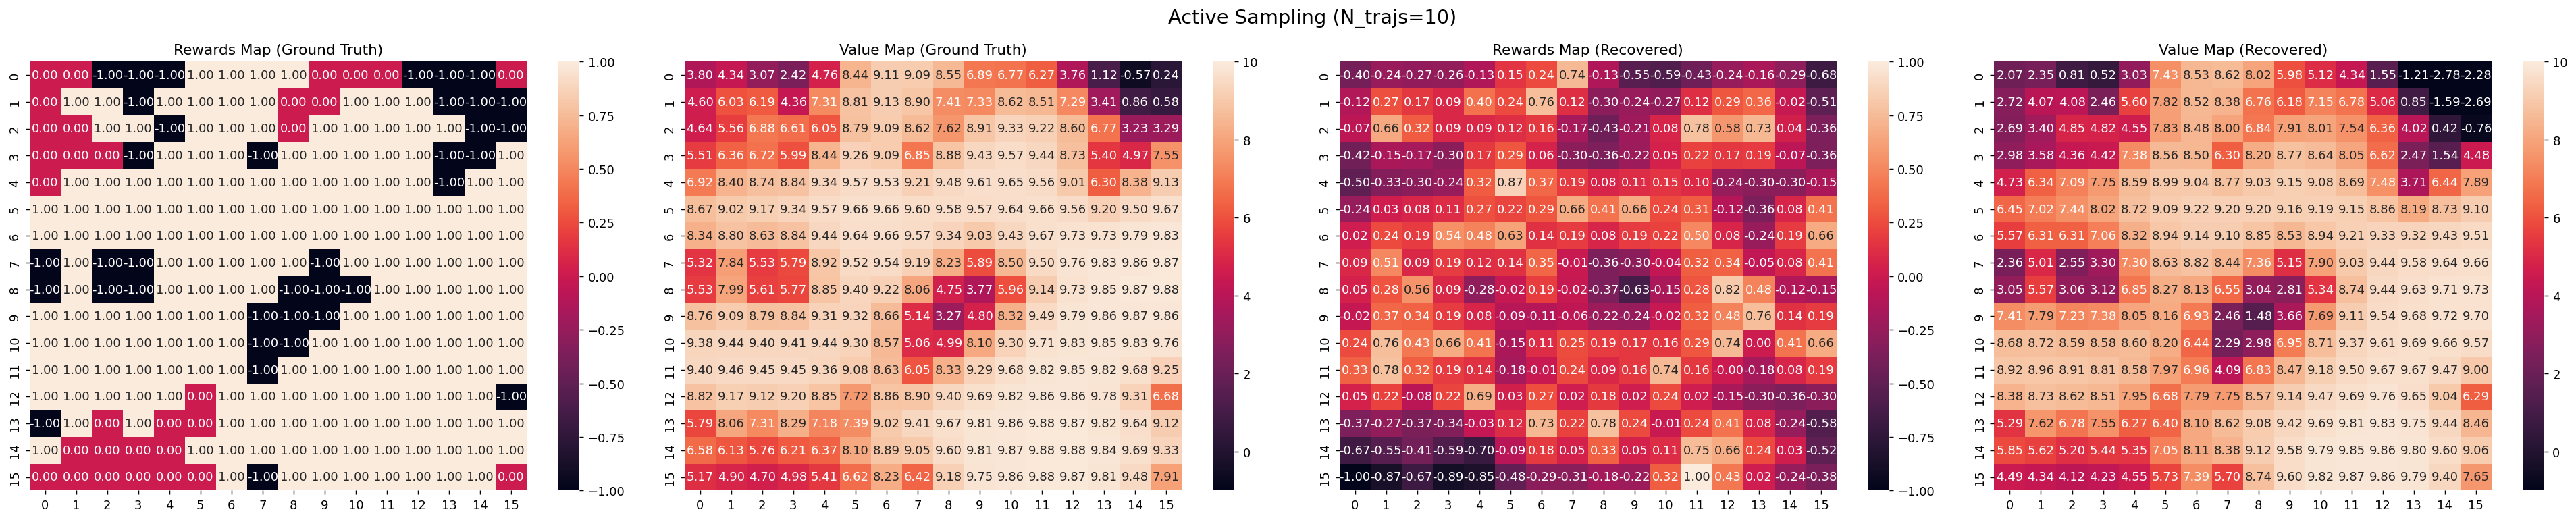

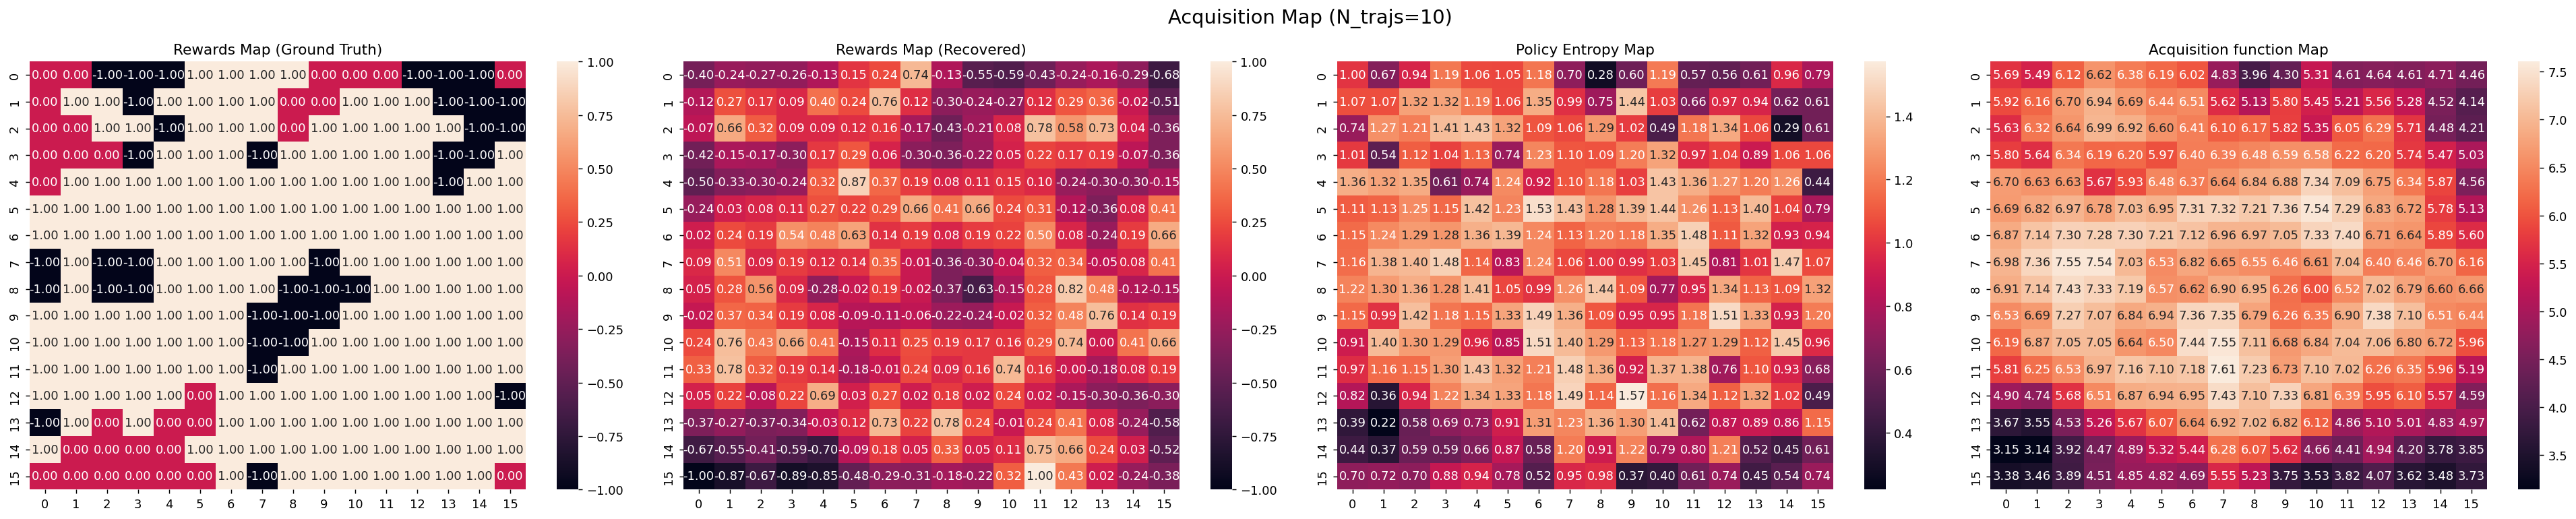

In [10]:
visualizer = Visualizer(history_deepmaxent_active, file_path=None, figsize=(30, 6), dpi=130)
n_trajs = 10
visualizer.draw_value_maps(search_idx=n_trajs)
visualizer.draw_acq_maps(search_idx=n_trajs)
visualizer.objectworld_reward_policy(search_idx=n_trajs)